# Importing and inspecting the data

We will start by importing the dataset

In [7]:
import pandas as pd
import numpy as np
# Set environment
pd.set_option('max_colwidth', 100)
pd.set_option('precision', 3)
# Read data
df_o=pd.read_csv('./data/train.csv',dtype={'question1':str,'question2':str},index_col='id')

df_o['is_duplicate'].value_counts(normalize=True)*100

0    63.08
1    36.92
Name: is_duplicate, dtype: float64

In [8]:
df_o.shape

(404290, 5)

In [4]:
df_o.dtypes

qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [166]:
df_o.drop_duplicates(inplace=True)
df_o.dropna(how='any',inplace=True)

In [167]:
df_o['question1']=df_o['question1'].astype('str')
df_o['question2']=df_o['question2'].astype('str')

In [9]:
df_o.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


## Split data

In [168]:
# Split dataset in training and validation dataset, 70/30
# Test dataset provided will not be used until the end, so it can be used for final validation
from sklearn. model_selection import train_test_split
TEST_SIZE = 0.3
X_train, X_val, y_train, y_val = train_test_split(df_o.loc[:,'qid1':'question2'], df_o.loc[:,'is_duplicate'], test_size=TEST_SIZE, random_state=42)
X_train.shape


(283001, 4)

## Pre processing

#### Stopwords removal

In [144]:
#Xs=X_train.head(100).copy()

In [169]:
import string
def clean_questions(df,low=True,stopwords=True,stem=True,punct=True):
    """ Add column of vector with words without stopwords, stem words and remove punctuation
    """
    
    stop_words=('my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'as', 'until', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn')
    df['q1_clean']=df['question1']
    df['q2_clean']=df['question2']
    
    if low :
        df.loc[:,'q1_clean']=df[['q1_clean']].apply(lambda q:[x.lower() for x in q])
        df.loc[:,'q2_clean']=df[['q2_clean']].apply(lambda q:[x.lower() for x in q])

    if punct :
        punctuation = set(string.punctuation)
        df.loc[:,'q1_clean']=df['q1_clean'].apply(lambda q: ''.join(ch for ch in q if ch not in punctuation))
        df.loc[:,'q2_clean']=df['q2_clean'].apply(lambda q: ''.join(ch for ch in q if ch not in punctuation))
    
    if stopwords :
        df.loc[:,'q1_clean']=df['q1_clean'].apply(lambda q:[x for x in q.split() if x not in stop_words])
        df.loc[:,'q2_clean']=df['q2_clean'].apply(lambda q:[x for x in q.split() if x not in stop_words])
        

In [170]:
clean_questions(X_train,low=True,stopwords=True,stem=False,punct=True)

In [279]:
clean_questions(X_val,low=True,stopwords=True,stem=False,punct=True)

#### Spell correction

In [15]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', 
                                                        binary=True)

words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [157]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [164]:
correction('sinonims')

'synonyms'

In [182]:
def spelling(df):
    """ Correct spelling
    """

    df.loc[:,'q1_clean']=df[['q1_clean']].apply(lambda q:[correction(x) for x in q])
    #df.loc[:,'q2_clean']=df['q2_clean'].apply(lambda q:[correction(x) for x in q])

# Generate features

Some ideas to work on:
1. Question lenght in words
2. Shared words
3. Use tf-idf to identify specific words on each pairs
4. Is question clause the same?
5. Syntax similarity: POS tags?
6. Shared synonyms (all words or just the key words- verb, object)
7. Similarity of key words: wordnet/synnet similarity score

### Take non-common words, calculate similarity and calculate a score

#### Feature: different length in words

In [126]:
def n_words(s):
    return(len(s.split()))

In [209]:
X_train['dif_len'].max(axis=0)

133

In [227]:
def dif_len(df):
    df['len1']=df['q1_clean'].apply(len)
    df['len2']=df['q2_clean'].apply(len)
    df['dif_len']=df['len1']-df['len2']
    df['dif_len']=df['dif_len'].apply(abs)
    max_len=df['dif_len'].max(axis=0)
    df['dif_len']=df['dif_len'].apply(lambda x: x/max_len)
    df.drop('len1',1,inplace=True)
    df.drop('len2',1,inplace=True)

In [228]:
dif_len(X_train)

In [280]:
dif_len(X_val)

In [281]:
X_val.head(20)

,qid1,qid2,question1,question2,q1_clean,q2_clean,dif_len
id,,,,,,,
8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,"[how, i, play, pokémon, go, korea]","[how, i, play, pokémon, go, china]",0.000
361084,490894,490895,How do you know if your photos on icloud are downloading?,How do I find my photos on iCloud?,"[how, know, if, photos, icloud, downloading]","[how, i, find, photos, icloud]",0.008
70497,121486,121487,"Which is more advisable and better material for a crash test in automobiles, ductile or brittle?",What is the best server setup for buddypress?,"[which, advisable, and, better, material, crash, test, automobiles, ductile, or, brittle]","[what, best, server, setup, buddypress]",0.048
226568,50715,121144,Which are some of the best comedy-thriller movies?,What is the best comedy movie ever?,"[which, best, comedythriller, movies]","[what, best, comedy, movie, ever]",0.008
73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,"[how, close, see, 3rd, world, war]","[how, close, world, war, iii]",0.008
215106,34749,320899,How do people like Noam Chomsky find so many trustworthy sources?,Why do some people hate Noam Chomsky? Can they prove him wrong?,"[how, people, like, noam, chomsky, find, many, trustworthy, sources]","[why, people, hate, noam, chomsky, prove, wrong]",0.016
178825,155611,199187,Are downvotes anonymous on Quora?,Will you be able to see the people who downvoted your answer on Quora?,"[downvotes, anonymous, quora]","[able, see, people, who, downvoted, answer, quora]",0.032
274791,248874,393471,What is the best place to visit in Bengaluru?,Which is the best place to see in Bangalore?,"[what, best, place, visit, bengaluru]","[which, best, place, see, bangalore]",0.000
104478,172497,172498,Why are cats so overprotective?,How do you know if your cat is overprotective?,"[why, cats, overprotective]","[how, know, if, cat, overprotective]",0.016


In [230]:
X_train['dif_len'].max(axis=0)

1.0

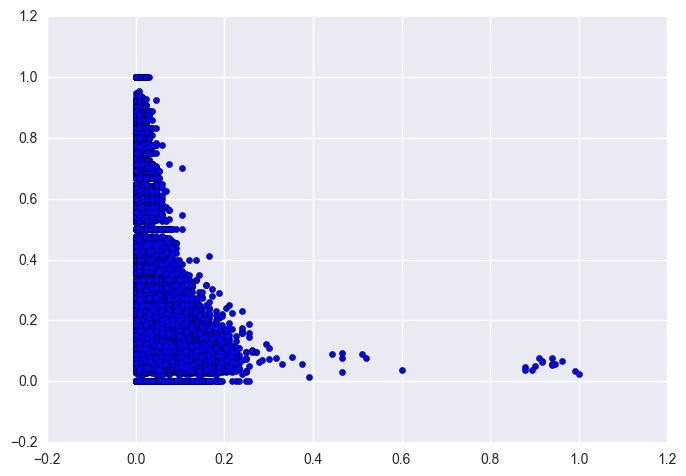

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(X_train['dif_len'],X_train['jacckard_dis'])
plt.show()

In [235]:
X_train=X_train[X_train['dif_len']<0.25]

In [ ]:
#X_val=X_val[X_val['dif_len']<0.25]

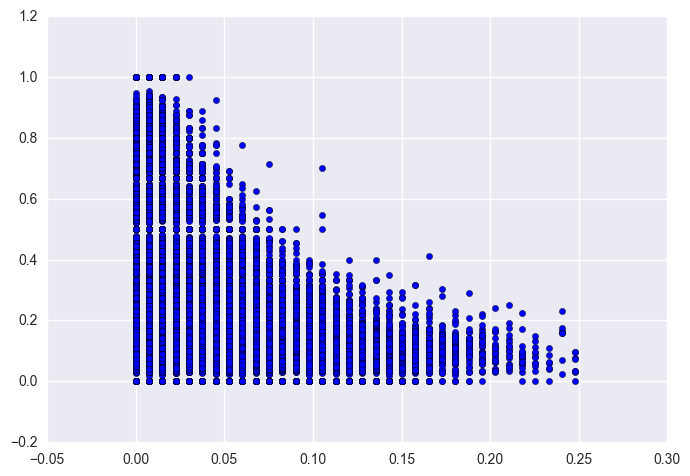

In [236]:
plt.scatter(X_train['dif_len'],X_train['jacckard_dis'])
plt.show()

#### Feature: Number of common words

#### Feature: Use tf-idf with cosine similarity


#### Feature: Shared synonyms

#### Feature: Ratio of common nouns (using Jaccard distance)

In [194]:
import nltk
def retrieve_word_pos_nltk(q,pos='N'):
    
    tagged=nltk.pos_tag(nltk.word_tokenize(q))
    return [item[0] for item in tagged if item[1][0] == pos]
    

In [195]:
def jaccard_dis(l1,l2):
    num=len(set(l1).intersection(l2))
    den=len(set(l1).union(l2))
    if den==0:
        return 0
    else:
        return(num/den)

In [86]:
#X_train.to_csv('X_train_nouns.csv')

In [198]:
def jaccard_dis_rows(row):
    l1=row['q1_clean']
    l2=row['q2_clean']
    num=len(set(l1).intersection(l2))
    den=len(set(l1).union(l2))
    if den==0:
        return 0
    else:
        return(num/den)

In [199]:
X_train.head()

,qid1,qid2,question1,question2,q1_clean,q2_clean,dif_len
id,,,,,,,
20128,37998,37999,"How is the working environment at SBI Life, Mumbai?",How stressful is work of SBI clerk?,"[how, working, environment, ski, life, mumbai]","[how, stressful, work, ski, clerk]",1
185202,282774,282775,What kinds of questions should I expect on the IBM CAT/IPAT?,What kinds of questions should I expect on the IBM IPAT?,"[what, kinds, questions, i, expect, ibm, catboat]","[what, kinds, questions, i, expect, ibm, pat]",0
107096,176275,176276,"On WhatsApp, it says on the message info that the message has been read with 2 blue ticks and no...",My friend is abroad and I have sent him messages. There is one grey tick next to the messages I ...,"[whatsapp, says, message, info, message, read, 2, blue, ticks, an, no, time, an, message, delive...","[friend, abroad, an, i, sent, messages, one, grew, tick, next, messages, i, recently, sent, but,...",13
27940,51849,51850,How do the holy scriptures of Hinduism compare and contrast to those of Taoism?,How do the holy scriptures of Hinduism compare and contrast to those of Italo-Roman paganism?,"[how, holy, scriptures, hinduism, compare, an, contrast, racism]","[how, holy, scriptures, hinduism, compare, an, contrast, italoroman, paganism]",1
244713,357399,357400,Does beard transplantation really work?,Is beard transplantation worthy?,"[beard, transplantation, really, work]","[beard, transplantation, worthy]",1


In [200]:
X_train['jacckard_dis']=X_train.apply(jaccard_dis_rows,axis=1)

In [282]:
X_val['jacckard_dis']=X_val.apply(jaccard_dis_rows,axis=1)

In [201]:
X_train.head()

,qid1,qid2,question1,question2,q1_clean,q2_clean,dif_len,jacckard_dis
id,,,,,,,,
20128,37998,37999,"How is the working environment at SBI Life, Mumbai?",How stressful is work of SBI clerk?,"[how, working, environment, ski, life, mumbai]","[how, stressful, work, ski, clerk]",1,0.222
185202,282774,282775,What kinds of questions should I expect on the IBM CAT/IPAT?,What kinds of questions should I expect on the IBM IPAT?,"[what, kinds, questions, i, expect, ibm, catboat]","[what, kinds, questions, i, expect, ibm, pat]",0,0.750
107096,176275,176276,"On WhatsApp, it says on the message info that the message has been read with 2 blue ticks and no...",My friend is abroad and I have sent him messages. There is one grey tick next to the messages I ...,"[whatsapp, says, message, info, message, read, 2, blue, ticks, an, no, time, an, message, delive...","[friend, abroad, an, i, sent, messages, one, grew, tick, next, messages, i, recently, sent, but,...",13,0.273
27940,51849,51850,How do the holy scriptures of Hinduism compare and contrast to those of Taoism?,How do the holy scriptures of Hinduism compare and contrast to those of Italo-Roman paganism?,"[how, holy, scriptures, hinduism, compare, an, contrast, racism]","[how, holy, scriptures, hinduism, compare, an, contrast, italoroman, paganism]",1,0.700
244713,357399,357400,Does beard transplantation really work?,Is beard transplantation worthy?,"[beard, transplantation, really, work]","[beard, transplantation, worthy]",1,0.400


## Compare non common words

In [4]:
X_train

NameError: name 'X_train' is not defined

# Applying models

In [37]:
y_train.head()

id
20128     0
185202    1
107096    0
27940     0
244713    1
Name: is_duplicate, dtype: int64

### Baseline algorithm

In [248]:
# Align y with X
XY_train=y_train.to_frame().merge(X_train, left_index=True, right_index=True)

ValueError: could not convert string to float: 'dif_len'

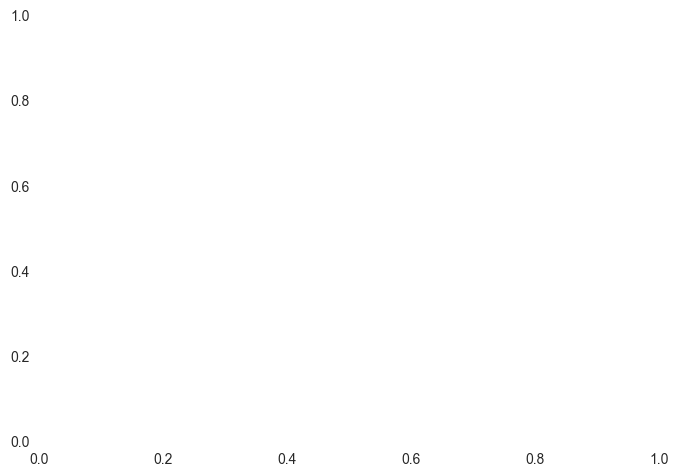

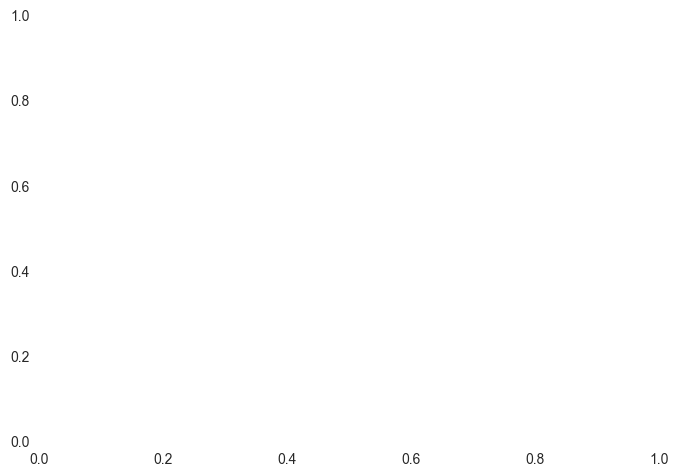

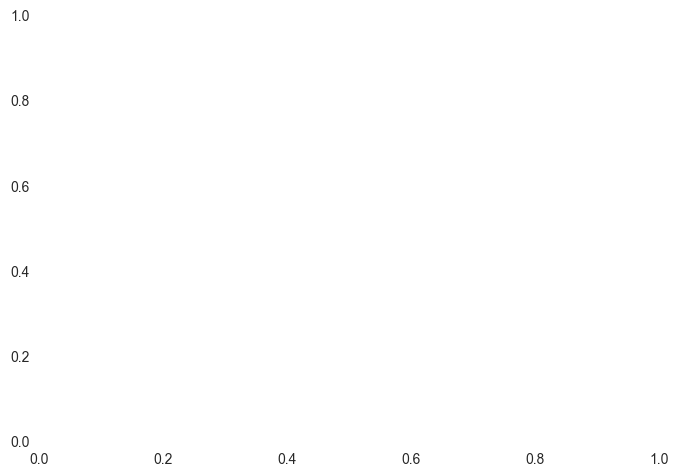

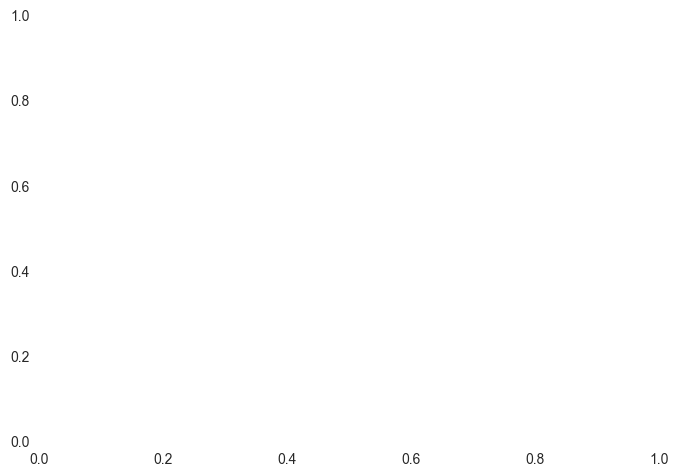

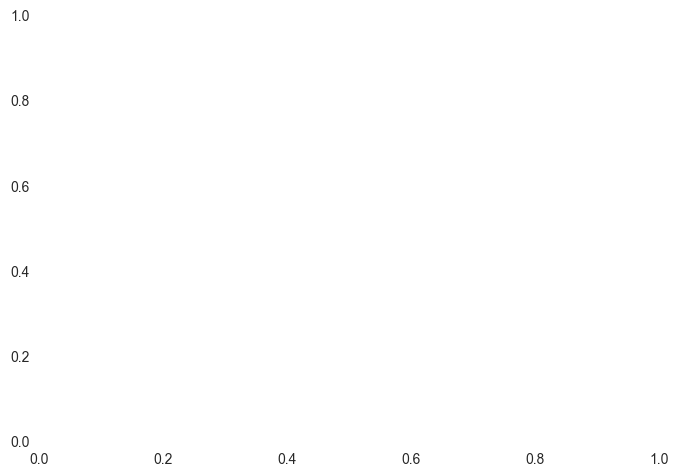

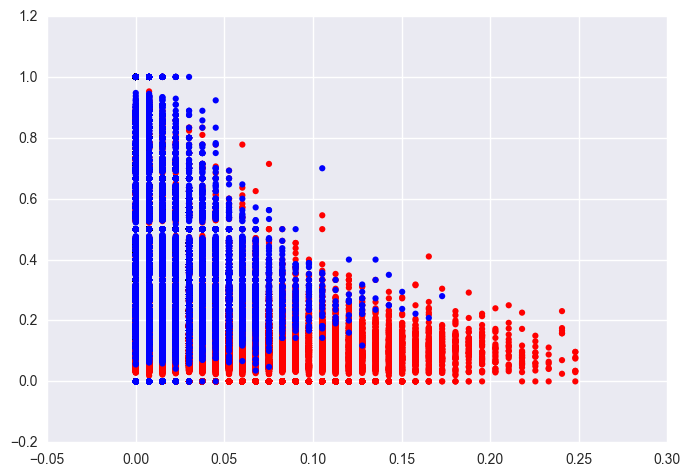

In [271]:
plt.scatter(XY_train['dif_len'][XY_train['is_duplicate']==0], XY_train['jacckard_dis'][XY_train['is_duplicate']==0], c="red", edgecolors='none')
plt.scatter(XY_train['dif_len'][XY_train['is_duplicate']==1], XY_train['jacckard_dis'][XY_train['is_duplicate']==1], c="blue", edgecolors='none')
plt.show()

In [76]:
X_train.loc[:,['ratio_nouns']].head()

,ratio_nouns
id,
20128,0.167
185202,0.500
107096,0.273
27940,0.625
244713,0.333


In [84]:
y_train.to_frame().head()

,is_duplicate
id,
20128,0
185202,1
107096,0
27940,0
244713,1


In [237]:
# We will take LogisticRegression as a simple algorithm to establish a baseline
from sklearn.linear_model import LogisticRegression
import numpy as np

In [126]:
logistic=LogisticRegression()
logistic.fit(X_train.loc[:,['ratio_nouns']],y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [127]:
logistic.score(X_train.loc[:,['ratio_nouns']],y_train)
# Score using Nouns

0.66010014098890113

In [283]:
logistic=LogisticRegression()
logistic.fit(XY_train.loc[:,['jacckard_dis']],XY_train['is_duplicate'])
logistic.score(X_val.loc[:,['jacckard_dis']],y_val)
# Score using all words

0.65786935120829104

### Other algorithms

In [18]:
# Flow: 
#   train model with a set of hyperparameters
#   Obtain score and iterate


# Run model on test dataset

# Results

Logistic regression + ratio of common nouns = 0.66


## TEST AREA

In [109]:
df_o[df_o['is_duplicate']==1][['question1','question2']]

,question1,question2
id,,
5,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?"
7,How can I be a good geologist?,What should I do to be a great geologist?
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?
12,What can make Physics easy to learn?,How can you make physics easy to learn?
13,What was your first sexual experience like?,What was your first sexual experience?
15,What would a Trump presidency mean for current international master’s students on an F1 visa?,How will a Trump presidency affect the students presently in US or planning to study in US?
16,What does manipulation mean?,What does manipulation means?
18,Why are so many Quora users posting questions that are readily answered on Google?,Why do people ask Quora questions which can be answered easily by Google?
20,Why do rockets look white?,Why are rockets and boosters painted white?
